In [9]:
# importing all libraries.
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.formula.api import ols
from sklearn import preprocessing
from scipy import stats

%matplotlib inline
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.linear_model import LinearRegression

In [10]:
# dropping extra index column.
df_clean_1 = pd.read_csv('df_clean_1.csv')
df_clean_1 = df_clean_1.drop(['Unnamed: 0'], axis=1)

In [11]:
# creating numpy arrays for the latitudes and longitudes of each house that is by the water.
water_lat = np.array(df_clean_1.loc[(df_clean_1['waterfront_bool'] == 1)]['lat'])
water_long = np.array(df_clean_1.loc[(df_clean_1['waterfront_bool'] == 1)]['long'])

# creating numpy arrays for latitudes and longitudes of each house.
house_lat = np.array(df_clean_1['lat'])
house_long = np.array(df_clean_1['long'])

In [12]:
# estimation of distance (in degrees) of each house to the coastline along latitude and longitude axes.
# this is done by taking each item in the house latitude and longitude arrays, and finding the nearest corresponding
# values in to a house on the waterfront.
lat_to_water = np.amin(np.absolute(house_lat[np.newaxis, :] - water_lat[:, np.newaxis]), axis=0)
long_to_water = np.amin(np.absolute(house_long[np.newaxis, :] - water_long[:, np.newaxis]), axis=0)

# adding the distances to the water (in degrees) to the dataframe.
df_clean_1['lat_to_water'] = lat_to_water
df_clean_1['long_to_water'] = long_to_water

In [13]:
# converting distance of latitude from degrees to kilometers using the formula:
# 1 degree of latitude = 110.574km.
df_clean_1['lat_to_water_km'] = df_clean_1['lat_to_water']*110.574

# converting latitude from degrees to radians.
df_clean_1['lat_rad'] = df_clean_1['lat']*math.pi/180

# converting distance of longitude from degrees to kilometres using the formula:
# 1 degree of longitude = 111.320 * latitude in radians.
df_clean_1['long_to_water_km'] = df_clean_1['long_to_water']*111.320*df_clean_1['lat_rad']

# finding the straight line distance to the coast using pythagoras' theorem:
df_clean_1['lat_to_water_sq'] = df_clean_1['lat_to_water_km']**2
df_clean_1['long_to_water_sq'] = df_clean_1['long_to_water_km']**2
df_clean_1['sum_sq'] = df_clean_1['lat_to_water_sq']+df_clean_1['long_to_water_sq']
df_clean_1['distance_to_water_km'] = df_clean_1['sum_sq']**0.5

In [14]:
# creating a new DF to play with and splitting target variable.
df_trial = df_clean_1.copy()
target = df_trial['price']
df_trial.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_of_sale,lat_to_water,long_to_water,lat_to_water_km,lat_rad,long_to_water_km,lat_to_water_sq,long_to_water_sq,sum_sq,distance_to_water_km
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,2014,0.0002,0.000,0.022115,0.829227,0.000000,0.000489,0.000000,0.000489,0.022115
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2014,0.0045,0.004,0.497583,0.832889,0.370869,0.247589,0.137544,0.385132,0.620590
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,2015,0.0025,0.002,0.276435,0.833184,0.185500,0.076416,0.034410,0.110827,0.332906
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,2014,0.0015,0.000,0.165861,0.829394,0.000000,0.027510,0.000000,0.027510,0.165861
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,2015,0.0005,0.014,0.055287,0.831070,1.295206,0.003057,1.677558,1.680615,1.296385


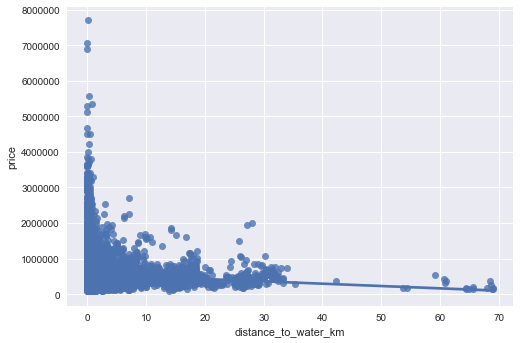

In [15]:
# initial trial to sense-check the correlation.
sns.regplot(df_trial['distance_to_water_km'], df_trial['price'])
plt.show()

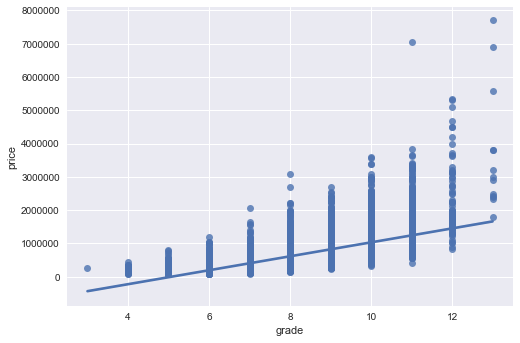

In [16]:
# based on the grouping and the high-price outliers, I imagine that some of the houses may be very large or
# very luxurious. I will consider another variable: grade.
sns.regplot(df_trial['grade'], df_trial['price'])
plt.show()

In [17]:
# grade data is ordinally categorical - so splitting it out into dummy variables.
grade_dummies = pd.get_dummies(df_trial['grade'])
grade_dummies_df = grade_dummies.sort_index()

In [18]:
# merging the dummy data with the main data in a new df.
df_merged = pd.concat([df_trial,grade_dummies_df], axis='columns')
df_merged_2 = df_merged.rename(columns={3: "d3", 4: "d4", 5: "d5",
                                        6: "d6", 7: "d7", 8: "d8",
                                        9: "d9", 10: "d10", 11: "d11",
                                        12: "d12", 13: "d13"})

In [19]:
# dropping the original grade column, and dropping one of the dummy columns to avoid the dummy variable trap.
df_ready = df_merged_2.drop(['grade','d13'],axis='columns')
df_ready.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,0,0,0,0,1,0,0,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
# splitting test and train data.
df_ready, df_test, target, target_test = train_test_split(df_ready,target, test_size=.2, random_state= 42)

In [21]:
# splitting out the chosen features into a smaller df.
df_small = df_ready[['d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','distance_to_water_km']]

# standardising the two features into z-scores.
df_small['z_distance_to_water_km'] = stats.zscore(df_small['distance_to_water_km'])
df_small['z_3'] = stats.zscore(df_small['d3'])
df_small['z_4'] = stats.zscore(df_small['d4'])
df_small['z_5'] = stats.zscore(df_small['d5'])
df_small['z_6'] = stats.zscore(df_small['d6'])
df_small['z_7'] = stats.zscore(df_small['d7'])
df_small['z_8'] = stats.zscore(df_small['d8'])
df_small['z_9'] = stats.zscore(df_small['d9'])
df_small['z_10'] = stats.zscore(df_small['d10'])
df_small['z_11'] = stats.zscore(df_small['d11'])
df_small['z_12'] = stats.zscore(df_small['d12'])

# splitting into standardised and unstandardised dfs.
df_unstandardised = df_small[['d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','distance_to_water_km']]
df_standardised = df_small[['z_3','z_4','z_5','z_6','z_7','z_8','z_9','z_10','z_11','z_12','z_distance_to_water_km']]

z_target = stats.zscore(target)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [22]:
# running the model with standardised data.
X_standardised = sm.add_constant(df_standardised)
model_standardised = sm.OLS(target,X_standardised)
results_standardised = model_standardised.fit()

results_standardised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     1745.
Date:                Fri, 27 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:15:55   Log-Likelihood:            -2.3748e+05
No. Observations:               17133   AIC:                         4.750e+05
Df Residuals:                   17121   BIC:                         4.751e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   5.394e+05   1935.622    278.667      0.000    5.36e+05    5.43e+05
z_3                    -2.708e+04   2030.541    -13.335      0.000   -3.11e+04   -2.31e+04
z_4                    -1.227e+05   3294.504    -37.253      0.000   -1.29e+05   -1.16e+05
z_5                    -3.786e+05   8589.048    -44.083      0.000   -3.95e+05   -3.62e+05
z_6                    -1.047e+06   2.34e+04    -44.749      0.000   -1.09e+06      -1e+06
z_7                    -1.723e+06   3.95e+04    -43.602      0.000    -1.8e+06   -1.65e+06
z_8                     -1.51e+06   3.61e+04    -41.830      0.000   -1.58e+06   -1.44e+06
z_9                    -1.019e+06   2.63e+04    -38.769      0.000   -1.07e+06   -9.68e+05
z_10                   -6.294e+05   1.79e+04    -35.129      0.000   -6.65e+05   -5.94e+05
z_11                   -3.217e+05   1.09e+04    -29.510      0.000   -3.43e+05      -3e+05
z_12                   -1.073e+05   5497.649    -19.516      0.000   -1.18e+05   -9.65e+04
z_distance_to_water_km -3.304e+04   1941.609    -17.019      0.000   -3.69e+04   -2.92e+04
==============================================================================
Omnibus:                    12650.322   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           724979.701
Skew:                           2.999   Prob(JB):                         0.00
Kurtosis:                      34.298   Cond. No.                         43.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# running the model with the fully standardised data.
X_standardised_all = sm.add_constant(df_standardised)
model_standardised_all = sm.OLS(z_target,X_standardised)
results_standardised_all = model_standardised_all.fit()
results_standardised_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     1745.
Date:                Fri, 27 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:15:55   Log-Likelihood:                -17869.
No. Observations:               17133   AIC:                         3.576e+04
Df Residuals:                   17121   BIC:                         3.585e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.107e-18      0.005  -1.74e-15      1.000      -0.010       0.010
z_3                       -0.0734      0.006    -13.335      0.000      -0.084      -0.063
z_4                       -0.3327      0.009    -37.253      0.000      -0.350      -0.315
z_5                       -1.0264      0.023    -44.083      0.000      -1.072      -0.981
z_6                       -2.8370      0.063    -44.749      0.000      -2.961      -2.713
z_7                       -4.6700      0.107    -43.602      0.000      -4.880      -4.460
z_8                       -4.0928      0.098    -41.830      0.000      -4.285      -3.901
z_9                       -2.7626      0.071    -38.769      0.000      -2.902      -2.623
z_10                      -1.7064      0.049    -35.129      0.000      -1.802      -1.611
z_11                      -0.8720      0.030    -29.510      0.000      -0.930      -0.814
z_12                      -0.2909      0.015    -19.516      0.000      -0.320      -0.262
z_distance_to_water_km    -0.0896      0.005    -17.019      0.000      -0.100      -0.079
==============================================================================
Omnibus:                    12650.322   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           724979.701
Skew:                           2.999   Prob(JB):                         0.00
Kurtosis:                      34.298   Cond. No.                         43.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# printing summary parameters
print('Parameters:')
print('-----------')
print('Constant:',round(results_standardised_all.params[0],3))
print('Z-grade-3:',round(results_standardised_all.params[1],3))
print('Z-grade-4:',round(results_standardised_all.params[2],3))
print('Z-grade-5:',round(results_standardised_all.params[3],3))
print('Z-grade-6:',round(results_standardised_all.params[4],3))
print('Z-grade-7:',round(results_standardised_all.params[5],3))
print('Z-grade-8:',round(results_standardised_all.params[6],3))
print('Z-grade-9:',round(results_standardised_all.params[7],3))
print('Z-grade-10:',round(results_standardised_all.params[8],3))
print('Z-grade-11:',round(results_standardised_all.params[9],3))
print('Z-grade-12:',round(results_standardised_all.params[10],3))
print('Z-distance to water:',round(results_standardised_all.params[11],3))

Parameters:
-----------
Constant: -0.0
Z-grade-3: -0.073
Z-grade-4: -0.333
Z-grade-5: -1.026
Z-grade-6: -2.837
Z-grade-7: -4.67
Z-grade-8: -4.093
Z-grade-9: -2.763
Z-grade-10: -1.706
Z-grade-11: -0.872
Z-grade-12: -0.291
Z-distance to water: -0.09


In [25]:
# this suggests that, the grade being held equal, the price will drop by 0.09 standard deviations for every
# increase in standard deviation in distance from the coast.

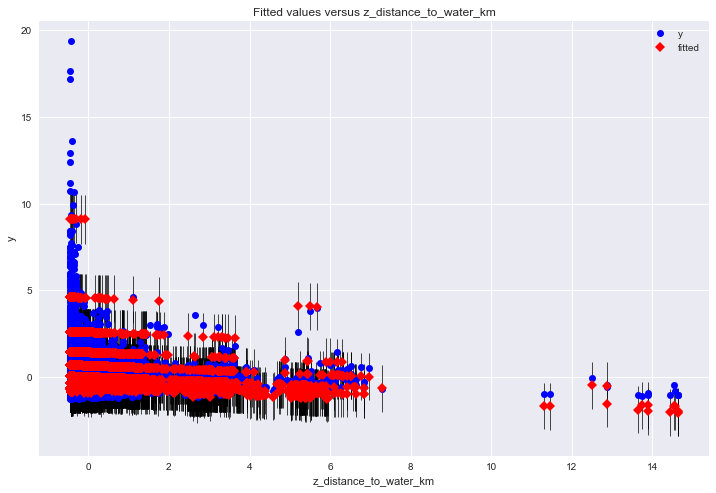

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results_standardised_all, "z_distance_to_water_km", ax=ax)

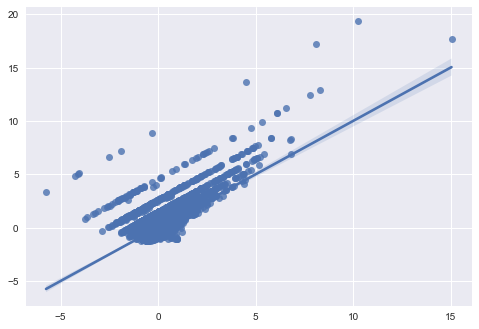

In [27]:
sns.regplot(results_standardised_all.resid, z_target)
plt.show()

In [28]:
# getting the test data ready to run
df_test_small = df_test[['d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','distance_to_water_km']]

In [29]:
# running the test data
X_test = sm.add_constant(df_test_small)
model_test = sm.OLS(target_test,X_test)
results_test = model_test.fit()

results_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     481.2
Date:                Fri, 27 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:15:57   Log-Likelihood:                -59309.
No. Observations:                4284   AIC:                         1.186e+05
Df Residuals:                    4273   BIC:                         1.187e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.058e+06   1.44e+05     21.241      0.000    2.78e+06    3.34e+06
d3                     1.44e-08   9.15e-10     15.744      0.000    1.26e-08    1.62e-08
d4                   -2.796e+06   1.69e+05    -16.558      0.000   -3.13e+06   -2.47e+06
d5                   -2.807e+06   1.49e+05    -18.874      0.000    -3.1e+06   -2.52e+06
d6                   -2.739e+06   1.45e+05    -18.954      0.000   -3.02e+06   -2.46e+06
d7                   -2.636e+06   1.44e+05    -18.288      0.000   -2.92e+06   -2.35e+06
d8                    -2.49e+06   1.44e+05    -17.271      0.000   -2.77e+06   -2.21e+06
d9                   -2.286e+06   1.44e+05    -15.828      0.000   -2.57e+06      -2e+06
d10                  -1.945e+06   1.45e+05    -13.424      0.000   -2.23e+06   -1.66e+06
d11                  -1.524e+06   1.47e+05    -10.401      0.000   -1.81e+06   -1.24e+06
d12                   -8.71e+05   1.57e+05     -5.551      0.000   -1.18e+06   -5.63e+05
distance_to_water_km -8227.4737    915.890     -8.983      0.000      -1e+04   -6431.854
==============================================================================
Omnibus:                     2712.231   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66237.613
Skew:                           2.606   Prob(JB):                         0.00
Kurtosis:                      21.545   Cond. No.                     8.21e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.38e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
# printing summary parameters
print('Parameters:')
print('-----------')
print('Constant:',round(results_test.params[0],3))
print('grade-3:',round(results_test.params[1],3))
print('grade-4:',round(results_test.params[2],3))
print('grade-5:',round(results_test.params[3],3))
print('grade-6:',round(results_test.params[4],3))
print('grade-7:',round(results_test.params[5],3))
print('grade-8:',round(results_test.params[6],3))
print('grade-9:',round(results_test.params[7],3))
print('grade-10:',round(results_test.params[8],3))
print('grade-11:',round(results_test.params[9],3))
print('grade-12:',round(results_test.params[10],3))
print('distance to water:',round(results_test.params[11],3))

Parameters:
-----------
Constant: 3058213.488
grade-3: 0.0
grade-4: -2796257.72
grade-5: -2806812.646
grade-6: -2739424.348
grade-7: -2635540.015
grade-8: -2489964.937
grade-9: -2285851.948
grade-10: -1945105.002
grade-11: -1524451.311
grade-12: -870999.494
distance to water: -8227.474


In [31]:
# creating a function to run the model on new data.
def predictor_trial(grade, distance_to_water_in_km):

    const = round(results_test.params[0],3)
    g_3 = round(results_test.params[1],3)
    g_4 = round(results_test.params[2],3)
    g_5 = round(results_test.params[3],3)
    g_6 = round(results_test.params[4],3)
    g_7 = round(results_test.params[5],3)
    g_8 = round(results_test.params[6],3)
    g_9 = round(results_test.params[7],3)
    g_10 = round(results_test.params[8],3)
    g_11 = round(results_test.params[9],3)
    g_12 = round(results_test.params[10],3)
    dist_coef = round(results_test.params[11],3)
    
    grade_list = [g_3,g_4,g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12]
        
    if grade in range(3,13):
        grade_coef = grade_list[grade-3]
    else:
        return "Grade value not in range"
    
    return print("$",round(const+(grade_coef)+(distance_to_water_in_km*dist_coef),0))

In [32]:
# running predictor function
predictor_trial(10,12)

$ 1014379.0


In [33]:
# investigating the difference between waterfront and non-waterfront houses.
waterfront_houses = df_trial.loc[(df_trial['waterfront_bool'] == 1)]
non_waterfront_houses = df_trial.loc[(df_trial['waterfront_bool'] == 0)]

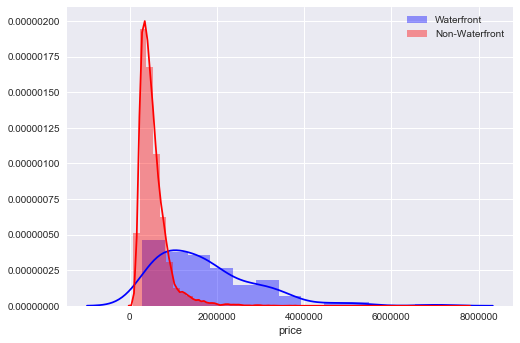

The mean price of a waterfront house is $ 1717215
The mean price of a non-waterfront house is $ 532560


In [34]:
# plotting the difference between waterfront and non-waterfront houses.
sns.distplot(waterfront_houses['price'], color='blue', label='Waterfront')
sns.distplot(non_waterfront_houses['price'], color='red', label='Non-Waterfront')
plt.legend()
plt.show()
print('The mean price of a waterfront house is $',round(waterfront_houses['price'].mean()))
print('The mean price of a non-waterfront house is $',round(non_waterfront_houses['price'].mean()))

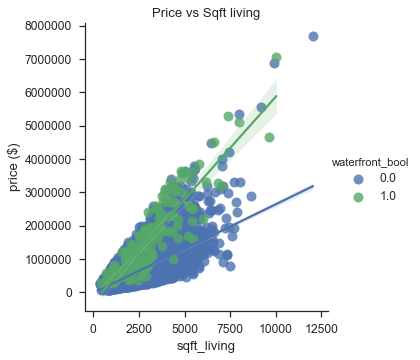

In [38]:
# plotting the difference taking size (square footage) into account.
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('sqft_living', 
           'price', 
           data=df_clean_1,
           hue = "waterfront_bool",
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100}) 


plt.title('Price vs Sqft living')
plt.xlabel('sqft_living')
plt.ylabel('price ($)')
plt.show()